In [ ]:
token = 'insert_your_neuprint_token_here'

from neuprint import Client

c = Client('neuprint.janelia.org', dataset='manc:v1.2.1', token=token)
c.fetch_version()
from neuprint import fetch_adjacencies
from neuprint import merge_neuron_properties

from neuprint.utils import connection_table_to_matrix

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


import networkx as nx



fig_path = 'C:/Users/LAB-JJ/Desktop/code/figs/'
plt.rcParams.update(plt.rcParamsDefault)
mpl.rcParams['pdf.fonttype']=42
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 11

In [ ]:
from neuprint import fetch_neurons, fetch_skeleton, NeuronCriteria as NC, fetch_synapses, SynapseCriteria as SC, skeleton_segments, fetch_synapse_connections

def make_connectome(neuron_list=None, type_list=None, syn_threshold=None):
        # Check which list is provided (neuron_list or type_list)
    if neuron_list is not None:
        # If neuron_list is provided, use it to fetch neuron data
        criteria = NC(bodyId=neuron_list)
        sn_df, sn_conn_df = fetch_neurons(criteria)
    elif type_list is not None:
        # If type_list is provided, use it to fetch neuron data based on type
        criteria = NC(type=type_list)
        sn_df, sn_conn_df = fetch_neurons(criteria)
    else:
        # Raise an error if neither list is provided
        raise ValueError("Either 'neuron_list' or 'type_list' must be provided.")
    

    #Fetch all downstream connections FROM a set of neurons
    sn_df_a, sn_conn_df_a = fetch_adjacencies(criteria, NC(status='Traced'))
    sn_conn_df_a['count'] = sn_conn_df_a.groupby('bodyId_post')['bodyId_post'].transform('size')
    sn_conn_df_filt = sn_conn_df_a[sn_conn_df_a.weight>=syn_threshold]

    all_ds_list = sn_conn_df_a.bodyId_post.unique()
    filt_ds_list = sn_conn_df_filt.bodyId_post.unique()

    conn_df_filt = merge_neuron_properties(sn_df_a, sn_conn_df_a, ['type', 'instance'])
    conn_df_filt.type_post.fillna(value='unknown', inplace=True)


    common_input = conn_df_filt.groupby(['bodyId_post'])['bodyId_post'].count().reset_index(name="common_input").sort_values(by=['common_input'], ascending=False).reset_index(drop=True)
    common_input_filtered = common_input[common_input["common_input"]>1] # filter out postsynaptic partners that don't share a lot of common input

    # just the downstream neuron information
    neuron_df_ds, conn_df_ds = fetch_neurons(NC(bodyId=all_ds_list))
    traced_ds_df = neuron_df_ds[neuron_df_ds.status=='Traced']

    conn_df_filt_MERGED = conn_df_filt.merge(neuron_df_ds, how='left', left_on='bodyId_post', right_on='bodyId')
    conn_df_filt_MERGED = conn_df_filt_MERGED[conn_df_filt_MERGED.status=='Traced']
    
    return conn_df_filt_MERGED
def separate_hemilineages(df):
    # make a dataframe for each tag

    unique_hemi_ids = df['hemilineage'].unique()

    # Create a dictionary to store the dataframes
    dfs = {}

    # Create a dataframe for each unique value in 'post_id'
    for hemi in unique_hemi_ids:
        # Filter the main dataframe based on the current 'post_id'

        if hemi == None:
            filtered_df = df[df['hemilineage'] == hemi].copy()

            # Add the filtered dataframe to the dictionary with the 'post_id' as the key
            dfs['unknown'] = filtered_df
        else:    
            filtered_df = df[df['hemilineage'] == hemi].copy()

            # Add the filtered dataframe to the dictionary with the 'post_id' as the key
            dfs[hemi] = filtered_df


    unknowns = dfs['TBD']
    unknowns = unknowns[unknowns.type_post=='unknown']

    MNs = dfs['TBD']
    MNs = MNs[MNs.type_post.str.contains('MN')]
    
    return dfs, unknowns, MNs
def make_tbar_postsynapses_df(neuron_list, conf_thres):    
    neuron_criteria = NC(status='Traced', bodyId=neuron_list)
    tbar_criteria = SC(type='pre')
    tbars = fetch_synapse_connections(NC(status='Traced'), neuron_criteria, tbar_criteria)
    tbars = tbars[tbars.confidence_pre>=conf_thres]

    post_criteria = SC(type='post')
    postsyns = fetch_synapse_connections(neuron_criteria, NC(status='Traced'), post_criteria)
    postsyns = postsyns[postsyns.confidence_post>=conf_thres]
    
    pre_df = tbars.groupby(['bodyId_pre','bodyId_post'])['bodyId_pre'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False)
    pre_df = pre_df.groupby('bodyId_post')['number_of_synapses'].sum().reset_index()
    post_df = postsyns.groupby(['bodyId_pre','bodyId_post'])['bodyId_post'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False)
    post_df = post_df.groupby('bodyId_pre')['number_of_synapses'].sum().reset_index()

    return pre_df, post_df, postsyns
def calculate_weight_signed(row):
    if row['predictedNt'] in ['gaba', 'glutamate']:
        return -1 * row['weight']
    else:  # For 'ach', return the weight as is
        return row['weight']   
def generate_combined(row):
    post = row['bodyId_post']
    lineage = row['hemilineage']
    class_ = row['class']
    
    if lineage is None:
        combined = f"{post}_{class_}"
    else:
        combined = f"{post}_{class_}_{lineage}"
    
    return combined
def calculate_proportions(df, neurons):
    size_info, _ = fetch_neurons(NC(bodyId=neurons))
    unique_posts = size_info.sort_values('synweight', ascending=False).bodyId.unique()
    
    pre_proportions = []
    weight_proportions = []
    labels = []
    
    for post in unique_posts:
        df_post = df[df['bodyId_post'] == post]
        
        # Filter DataFrame based on type_pre containing "SN"
        df_sn = df_post[df_post['type_pre'].str.contains('|'.join(["SNch01",'SNxx29','SNxx25', 'SAxx02']))]
        df_non_sn = df_post[~df_post['type_pre'].str.contains('|'.join(["SNch01",'SNxx29','SNxx25', 'SAxx02']))]

        # Calculate the number of unique pre values for each category
        num_pre_sn = df_sn['bodyId_pre'].nunique()
        num_pre_non_sn = df_non_sn['bodyId_pre'].nunique()
        total_pre = df_post['bodyId_pre'].nunique()

        # Calculate the proportions for pre values
        prop_pre_sn = num_pre_sn / total_pre if total_pre != 0 else 0
        prop_pre_non_sn = num_pre_non_sn / total_pre if total_pre != 0 else 0

        # Calculate the sum of weight for each category
        weight_sum_sn = df_sn['weight'].sum()
        weight_sum_non_sn = df_non_sn['weight'].sum()
        total_weight_sum = df_post['weight'].sum()

        # Calculate the proportions for weight sum
        prop_weight_sum_sn = weight_sum_sn / total_weight_sum if total_weight_sum != 0 else 0
        prop_weight_sum_non_sn = weight_sum_non_sn / total_weight_sum if total_weight_sum != 0 else 0

        pre_proportions.append([prop_pre_sn * 100, prop_pre_non_sn * 100])
        weight_proportions.append([prop_weight_sum_sn * 100, prop_weight_sum_non_sn * 100])
        labels.append(post)

    return pre_proportions, weight_proportions, labels
def calculate_pre_proportions(df, neurons, types_of_interest):
    size_info, _ = fetch_neurons(NC(bodyId=neurons))
    unique_posts = size_info.sort_values('synweight', ascending=False).bodyId.unique()

    # Initialize lists to hold proportions
    type_proportions = {t: [] for t in types_of_interest}
    type_proportions['Other'] = []
    weight_proportions = {t: [] for t in types_of_interest}
    weight_proportions['Other'] = []
    labels = []

    for post in unique_posts:
        df_post = df[df['bodyId_post'] == post]

        # Calculate total counts and weights
        total_pre = df_post['bodyId_pre'].nunique()
        total_weight_sum = df_post['weight'].sum()

        for t in types_of_interest:
            df_type = df_post[df_post['type_pre'].str.contains(t)]
            num_pre_type = df_type['bodyId_pre'].nunique()
            weight_sum_type = df_type['weight'].sum()

            prop_pre_type = num_pre_type / total_pre if total_pre != 0 else 0
            prop_weight_sum_type = weight_sum_type / total_weight_sum if total_weight_sum != 0 else 0

            type_proportions[t].append(prop_pre_type * 100)
            weight_proportions[t].append(prop_weight_sum_type * 100)

        # Calculate proportions for 'Other' category
        df_other = df_post[~df_post['type_pre'].str.contains('|'.join(types_of_interest))]
        num_pre_other = df_other['bodyId_pre'].nunique()
        weight_sum_other = df_other['weight'].sum()

        prop_pre_other = num_pre_other / total_pre if total_pre != 0 else 0
        prop_weight_sum_other = weight_sum_other / total_weight_sum if total_weight_sum != 0 else 0

        type_proportions['Other'].append(prop_pre_other * 100)
        weight_proportions['Other'].append(prop_weight_sum_other * 100)

        labels.append(post)

    # Ensure proportions have correct lengths
    pre_proportions = [type_proportions[t] for t in types_of_interest + ['Other']]
    weight_proportions = [weight_proportions[t] for t in types_of_interest + ['Other']]

    return pre_proportions, weight_proportions, labels
def calculate_post_proportions(df, neurons, types_of_interest):
    size_info, _ = fetch_neurons(NC(bodyId=neurons))
    unique_posts = size_info.sort_values('synweight', ascending=False).bodyId.unique()

    # Initialize lists to hold proportions
    type_proportions = {t: [] for t in types_of_interest}
    type_proportions['Other'] = []
    weight_proportions = {t: [] for t in types_of_interest}
    weight_proportions['Other'] = []
    labels = []

    for post in unique_posts:
        df_post = df[df['bodyId_pre'] == post]

        # Calculate total counts and weights
        total_pre = df_post['bodyId_post'].nunique()
        total_weight_sum = df_post['weight'].sum()

        for t in types_of_interest:
            df_type = df_post[df_post['type_post'].str.contains(t)]
            num_pre_type = df_type['bodyId_post'].nunique()
            weight_sum_type = df_type['weight'].sum()

            prop_pre_type = num_pre_type / total_pre if total_pre != 0 else 0
            prop_weight_sum_type = weight_sum_type / total_weight_sum if total_weight_sum != 0 else 0

            type_proportions[t].append(prop_pre_type * 100)
            weight_proportions[t].append(prop_weight_sum_type * 100)

        # Calculate proportions for 'Other' category
        df_other = df_post[~df_post['type_post'].str.contains('|'.join(types_of_interest))]
        num_pre_other = df_other['bodyId_post'].nunique()
        weight_sum_other = df_other['weight'].sum()

        prop_pre_other = num_pre_other / total_pre if total_pre != 0 else 0
        prop_weight_sum_other = weight_sum_other / total_weight_sum if total_weight_sum != 0 else 0

        type_proportions['Other'].append(prop_pre_other * 100)
        weight_proportions['Other'].append(prop_weight_sum_other * 100)

        labels.append(post)

    # Ensure proportions have correct lengths
    post_proportions = [type_proportions[t] for t in types_of_interest + ['Other']]
    weight_proportions = [weight_proportions[t] for t in types_of_interest + ['Other']]

    return post_proportions, weight_proportions, labels
def connectome_cleanup(conn_df, neurons):
    
    pre_df, post_df, postsyns = make_tbar_postsynapses_df(neurons, 0.95)

    downstream_neurons = postsyns.bodyId_post.unique()
    _store =[]
    cat_cnt = 0

    for _id in downstream_neurons:
        df = postsyns[postsyns['bodyId_pre'] == _id]
        df_grouped = df.groupby(['bodyId_pre','bodyId_post'])['bodyId_post'].count().reset_index(name="weight").sort_values(by=['weight'], ascending=False).reset_index(drop=True)

        # append this dataframe
        _store.append(df_grouped)

        # concatenate dataframes
        if cat_cnt == 0:
            cat_df = df_grouped
            cat_cnt=1
        else:
            cat_df = pd.concat([cat_df, df_grouped], ignore_index=True)


    high_confidence_ds_df = cat_df.merge(conn_df[['bodyId_pre','bodyId_post','predictedNt','type_pre','instance_pre',
                                                            'type_post', 'instance_post','roi','class','hemilineage']], 
                                                            on=['bodyId_pre', 'bodyId_post'], how='inner')        
    
    return pre_df, post_df, high_confidence_ds_df
def plot_stacked_NT_barplot(data , columnId=None, columnInstance=None):
    ntCount = data.groupby([columnId,'predictedNt'])['predictedNt'].count().reset_index(name='ntCount')
    ntCount_tot = data.groupby([columnId])['predictedNt'].count().reset_index(name='ntCount_total')

    merged_df = pd.merge(ntCount, ntCount_tot, on=columnId, suffixes=('_individual', '_total'))

    # Step 2: Calculate percentages
    merged_df['proportion'] = (merged_df['ntCount'] / merged_df['ntCount_total'])

    # Step 3: Pivot the DataFrame for plotting
    pivot_df = merged_df.pivot_table(index=columnId, columns='predictedNt', values='proportion', fill_value=0)
    Ids = data.sort_values(columnInstance, ascending=True).bodyId_pre.unique()
    
    return pivot_df, Ids
def plot_stacked_class_weight_barplot(data , columnId=None, columnInstance=None):
    ntCount = data.groupby([columnId,'class'])['weight'].sum().reset_index(name='classWeight')
    ntCount_tot = data.groupby([columnId])['weight'].sum().reset_index(name='classWeight_total')

    merged_df = pd.merge(ntCount, ntCount_tot, on=columnId, suffixes=('_individual', '_total'))

    # Step 2: Calculate percentages
    merged_df['proportion'] = (merged_df['classWeight'] / merged_df['classWeight_total'])

    # Step 3: Pivot the DataFrame for plotting
    pivot_df = merged_df.pivot_table(index=columnId, columns='class', values='proportion', fill_value=0)
    Ids = data.sort_values(columnInstance, ascending=True).bodyId_pre.unique()
    
    return pivot_df, Ids
def plot_stacked_class_count_barplot(data , columnId=None, columnInstance=None):
    ntCount = data.groupby([columnId,'class'])['class'].count().reset_index(name='classCount')
    ntCount_tot = data.groupby([columnId])['class'].count().reset_index(name='classCount_total')

    merged_df = pd.merge(ntCount, ntCount_tot, on=columnId, suffixes=('_individual', '_total'))

    # Step 2: Calculate percentages
    merged_df['proportion'] = (merged_df['classCount'] / merged_df['classCount_total'])

    # Step 3: Pivot the DataFrame for plotting
    pivot_df = merged_df.pivot_table(index=columnId, columns='class', values='proportion', fill_value=0)
    Ids = data.sort_values(columnInstance, ascending=True).bodyId_pre.unique()
    
    return pivot_df, Ids


In [5]:
#all SNch01:
md_4_neurons = [23532, 163802, 22217, 25494, 25636, 18951, 21105, 22543, 22045, 
                22090, 23476, 23783, 24180, 26664, 154741, 21773, 21209, 21219, 
                22411, 22995, 24165, 101527, 152738, 22228, 15915, 21976, 22123, 
                22247, 23242, 23392, 15263, 22613, 22719, 23684, 25586, 25658]

conn_df_filt_MERGED = make_connectome(md_4_neurons, 5)
pre_df, post_df, high_confidence_ds_df = connectome_cleanup(conn_df_filt_MERGED, md_4_neurons)

exclude = [15915, 23242, 23392, 23684, 25586, 25658]  #these are most likely another type
high_confidence_ds_df = high_confidence_ds_df[~high_confidence_ds_df.bodyId_pre.isin([exclude])]

C:\Users\LAB-JJ\AppData\Local\Temp\ipykernel_15852\3320143495.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  conn_df_filt.type_post.fillna(value='unknown', inplace=True)


  0%|          | 0/14217 [00:00<?, ?it/s]

  0%|          | 0/68342 [00:00<?, ?it/s]

0.3794742069729907
0.03861854638364175


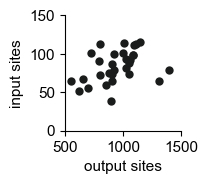

In [6]:
#plt.rcParams.update(plt.rcParamsDefault)
import matplotlib
import scipy as sp
#matplotlib.rc('axes', edgecolor='black', labelcolor='black')
#matplotlib.rc('xtick', color='black'); matplotlib.rc('ytick', color='black')

manc_inout = post_df[~post_df.bodyId_pre.isin(exclude)].merge(pre_df, left_on='bodyId_pre', right_on='bodyId_post')

fig = plt.figure(figsize=(1.5,1.5))
ax = sns.scatterplot(data=manc_inout[['number_of_synapses_x', 'number_of_synapses_y']], y='number_of_synapses_y', 
            x='number_of_synapses_x', color="#1a1b1b",lw=0)

r, p = sp.stats.pearsonr(manc_inout['number_of_synapses_y'], manc_inout['number_of_synapses_x'])
print (r)
print (p)

plt.xticks(np.arange(500,1501, 500))
plt.yticks(np.arange(0,151, 50))
plt.xlabel('output sites'); plt.ylabel('input sites')
sns.despine(trim=True)
plt.show()


C:\Users\LAB-JJ\AppData\Local\Temp\ipykernel_15852\2143258801.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


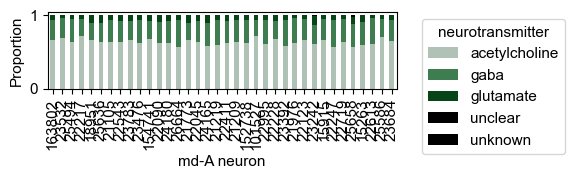

In [ ]:
# Step 4: Create the stacked bar plot

colors = ['#b0c2b5', '#3e7d50', '#074518', 'black']
cmap = ListedColormap(colors)

# Plot the data
fig, ax = plt.subplots(figsize=(4.5, 1))
pivot_df, ids = plot_stacked_NT_barplot(high_confidence_ds_df, 'bodyId_pre', 'instance_pre')
pivot_df.reindex(ids).plot(kind='bar', stacked=True, colormap=cmap, ax=ax)
# Set plot labels and title
ax.set_xlabel('md-A neuron')
ax.set_ylabel('Proportion')
#ax.set_title('Proportion of Each predictedNt per bodyId_pre')
ax.legend(title='neurotransmitter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [8]:
#change "sensory ascending' to 'sensory neuron'
high_confidence_ds_df['class'] = high_confidence_ds_df['class'].replace({'sensory ascending': 'sensory neuron', 'efferent ascending': 'efferent neuron'})
high_confidence_ds_df = high_confidence_ds_df[~high_confidence_ds_df['class'].str.contains('TBD')]


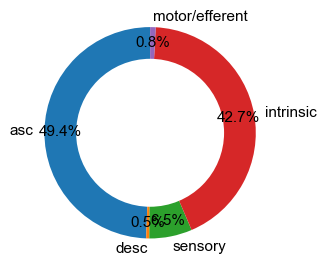

In [ ]:
fig = plt.figure(figsize=(3, 3))
# Data for the donut chart
sizes = [high_confidence_ds_df[high_confidence_ds_df['class']=='ascending neuron']['weight'].sum(), 
         high_confidence_ds_df[high_confidence_ds_df['class']=='descending neuron']['weight'].sum(),
         high_confidence_ds_df[high_confidence_ds_df['class']=='sensory neuron']['weight'].sum(),
         high_confidence_ds_df[high_confidence_ds_df['class']=='intrinsic neuron']['weight'].sum(),
         high_confidence_ds_df[high_confidence_ds_df['class'].isin(['motor neuron', 'efferent neuron'])]['weight'].sum(),]
labels = ['asc', 'desc', 'sensory', 'intrinsic', 'motor/efferent']

# Create the pie chart
plt.pie(sizes, labels=labels,  autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a white circle in the center to create the donut hole
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()

In [10]:
proprioceptors_df= pd.read_csv('C:/Users/LAB-JJ/Desktop/code/proprioceptors_connectome.csv')
bristles_df = pd.read_csv('C:/Users/LAB-JJ/Desktop/code/bristles_connectome.csv')


C:\Users\LAB-JJ\AppData\Local\Temp\ipykernel_15852\2142506826.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  asc = proprioceptors_df[proprioceptors_df['class']=='ascending neuron'][proprioceptors_df.weight>=4]


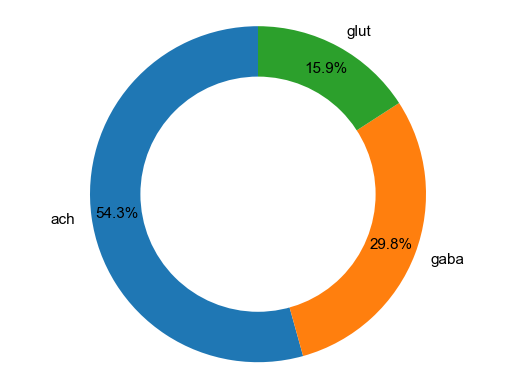

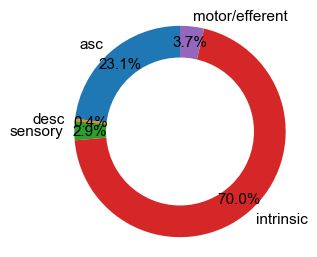

In [ ]:
#plot 1
asc = proprioceptors_df[proprioceptors_df['class']=='ascending neuron'][proprioceptors_df.weight>=4]
sizes = [asc[asc['predictedNt']=='acetylcholine']['weight'].sum(), 
         asc[asc['predictedNt']=='gaba']['weight'].sum(),
            asc[asc['predictedNt']=='glutamate']['weight'].sum(),]
labels = ['ach', 'gaba', 'glut']

# Create the pie chart
plt.pie(sizes, labels=labels,  autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a white circle in the center to create the donut hole
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()

# plot 2
fig = plt.figure(figsize=(3, 3))
# Data for the donut chart
sizes = [proprioceptors_df[proprioceptors_df['class']=='ascending neuron']['weight'].sum(), 
         proprioceptors_df[proprioceptors_df['class']=='descending neuron']['weight'].sum(),
         proprioceptors_df[proprioceptors_df['class']=='sensory neuron']['weight'].sum(),
         proprioceptors_df[proprioceptors_df['class']=='intrinsic neuron']['weight'].sum(),
         proprioceptors_df[proprioceptors_df['class'].isin(['motor neuron', 'efferent neuron'])]['weight'].sum(),]
labels = ['asc', 'desc', 'sensory', 'intrinsic', 'motor/efferent']

# Create the pie chart
plt.pie(sizes, labels=labels,  autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a white circle in the center to create the donut hole
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()



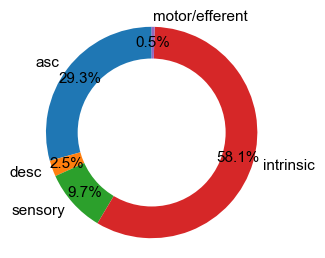

C:\Users\LAB-JJ\AppData\Local\Temp\ipykernel_15852\869773336.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  asc = bristles_df[bristles_df['class']=='ascending neuron'][bristles_df.weight>=4]


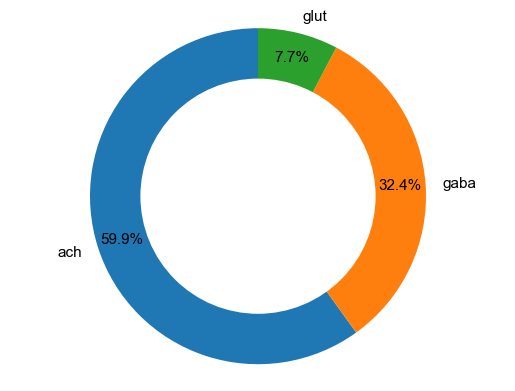

In [12]:

fig = plt.figure(figsize=(3, 3))
# Data for the donut chart
sizes = [bristles_df[bristles_df['class']=='ascending neuron']['weight'].sum(), 
         bristles_df[bristles_df['class']=='descending neuron']['weight'].sum(),
         bristles_df[bristles_df['class']=='sensory neuron']['weight'].sum(),
         bristles_df[bristles_df['class']=='intrinsic neuron']['weight'].sum(),
         bristles_df[bristles_df['class'].isin(['motor neuron', 'efferent neuron'])]['weight'].sum(),]
labels = ['asc', 'desc', 'sensory', 'intrinsic', 'motor/efferent']
#colors = ["#9de49d","#0e5024"] # Optional custom colors

# Create the pie chart
plt.pie(sizes, labels=labels,  autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a white circle in the center to create the donut hole
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()

asc = bristles_df[bristles_df['class']=='ascending neuron'][bristles_df.weight>=4]
sizes = [bristles_df[bristles_df['predictedNt']=='acetylcholine']['weight'].sum(), 
         bristles_df[bristles_df['predictedNt']=='gaba']['weight'].sum(),
            bristles_df[bristles_df['predictedNt']=='glutamate']['weight'].sum(),]
labels = ['ach', 'gaba', 'glut']
#colors = ["#9de49d","#0e5024"] # Optional custom colors

# Create the pie chart
plt.pie(sizes, labels=labels,  autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a white circle in the center to create the donut hole
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()

C:\Users\LAB-JJ\AppData\Local\Temp\ipykernel_15852\229550861.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  asc = high_confidence_ds_df[high_confidence_ds_df['class']=='ascending neuron'][high_confidence_ds_df.weight>=4]


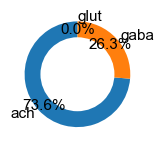

In [13]:
fig = plt.figure(figsize=(1.5, 1.5))
# Data for the donut chart
asc = high_confidence_ds_df[high_confidence_ds_df['class']=='ascending neuron'][high_confidence_ds_df.weight>=4]
sizes = [asc[asc['predictedNt']=='acetylcholine']['weight'].sum(), 
         asc[asc['predictedNt']=='gaba']['weight'].sum(),
            asc[asc['predictedNt']=='glutamate']['weight'].sum(),]
labels = ['ach', 'gaba', 'glut']
#colors = ["#9de49d","#0e5024"] # Optional custom colors

# Create the pie chart
plt.pie(sizes, labels=labels,  autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a white circle in the center to create the donut hole
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

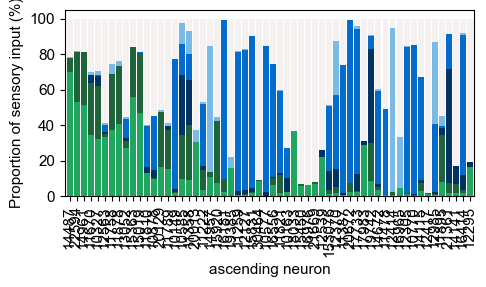

In [14]:
criteria = NC(class_='sensory neuron')
sn_df, sn_conn_df = fetch_neurons(criteria)

proprioceptors = sn_df[sn_df.type.str.contains('pp')].bodyId.unique()
tactile = sn_df[sn_df.type.str.contains('ta')].bodyId.unique()
multidendritic = sn_df[sn_df.type.str.contains('SNch01')].bodyId.unique()
other_aversive_types = sn_df[sn_df.type.str.contains('SNxx29|SNxx25|SAxx02')].bodyId.unique()
chemoreceptors = sn_df[(sn_df.type.str.contains('ch'))&(sn_df.type!='SNch01')].bodyId.unique()

a, b = fetch_adjacencies(NC(class_=['sensory neuron', 'sensory ascending']), NC(bodyId=asc[asc.predictedNt=='acetylchoine'].bodyId_post.unique()))

#a, b = fetch_adjacencies(NC(status='Traced'), NC(bodyId=asc.bodyId_post.unique()))

# Calculate the percentage of weight from multidendritic, proprioceptors, and tactile for each unique bodyId_post in b
combined_list = list(proprioceptors) + list(multidendritic) + list(tactile) + list(other_aversive_types) + list(chemoreceptors)

sensory_inputs = []
for post in asc.bodyId_post.unique():
    df_post = b[b['bodyId_post'] == post]
    
    total_weight = df_post['weight'].sum()
    md_weight = df_post[df_post['bodyId_pre'].isin(multidendritic)]['weight'].sum()
    pp_weight = df_post[df_post['bodyId_pre'].isin(proprioceptors)]['weight'].sum()
    ta_weight = df_post[df_post['bodyId_pre'].isin(tactile)]['weight'].sum()
    chemo_weight = df_post[df_post['bodyId_pre'].isin(chemoreceptors)]['weight'].sum()
    aversive_weight = df_post[df_post['bodyId_pre'].isin(other_aversive_types)]['weight'].sum()
    other_sensory_weight = df_post[~df_post['bodyId_pre'].isin(combined_list)]['weight'].sum()
    
    md_percentage = (md_weight / total_weight * 100) if total_weight > 0 else 0
    pp_percentage = (pp_weight / total_weight * 100) if total_weight > 0 else 0
    ta_percentage = (ta_weight / total_weight * 100) if total_weight > 0 else 0
    chemo_percentage = (chemo_weight / total_weight * 100) if total_weight > 0 else 0
    aversive_percentage = (aversive_weight / total_weight * 100) if total_weight > 0 else 0
    other_percentage = (other_sensory_weight / total_weight * 100) if total_weight > 0 else 0
    
    sensory_inputs.append({
        'bodyId_post': post,
        'md_percentage': md_percentage,
        'aversive_types_percentage': aversive_weight / total_weight * 100 if total_weight > 0 else 0,
        'pp_percentage': pp_percentage,
        'ta_percentage': ta_percentage,
        'chemo_percentage': chemo_percentage,
        'other_percentage': other_percentage
    })

# make sensory_inputs a dataframe for easier plotting
sensory_inputs_df = pd.DataFrame(sensory_inputs)

#plot percentages as stacked barplot
fig, ax = plt.subplots(figsize=(5,3))    

sensory_inputs_df.set_index('bodyId_post').reindex(asc.sort_values('weight', ascending=False)['bodyId_post'].unique()).plot(
	kind='bar',
	stacked=True,
	color=["#21a660", "#1E633A", "#003363", "#036bcc", "#79bae6", "#f5f1f1"],
	ax=ax,
	width=0.85,  # Reduce bar width to decrease space between bars
    legend=False
)
# Set plot labels and title
ax.set_xlabel('ascending neuron')
ax.set_ylabel('Proportion of sensory input (%)')
#ax.set_title('Proportion of Each predictedNt per bodyId_pre')
#remove legend
plt.tight_layout()
plt.show()

c:\Users\LAB-JJ\Anaconda3\envs\manc_env\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\LAB-JJ\Anaconda3\envs\manc_env\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


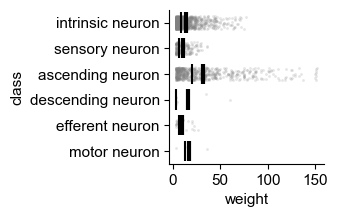

In [15]:

custom_order = ['intrinsic neuron','sensory neuron', 'ascending neuron','descending neuron', 'efferent neuron', 'motor neuron']

fig= plt.figure(figsize=(2,2))


ax = sns.stripplot(data=high_confidence_ds_df[high_confidence_ds_df.weight>=4], 
                   jitter=.25,

                   y='class', x='weight',
                   color='grey', 
                   alpha=.2, 
                   size=2,
                   order=custom_order)

ax = sns.boxplot(data=high_confidence_ds_df[high_confidence_ds_df.weight>=4], 
                 y='class', x='weight',
                showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 3},
                 #medianprops={'visible': True},
                 whiskerprops={'visible': False},
                color="#000000",
                 zorder=10,
                 showfliers=False,
                 fill=False,
                showbox=False,
                showcaps=False,
                # width=.5,
                 order=custom_order)
plt.xticks([0,50,100,150])
sns.despine()
plt.show()
fig.savefig('C:/Users/LAB-JJ/Desktop/code/figs/manc_downstream_class_stripplot_.svg', transparent=True)


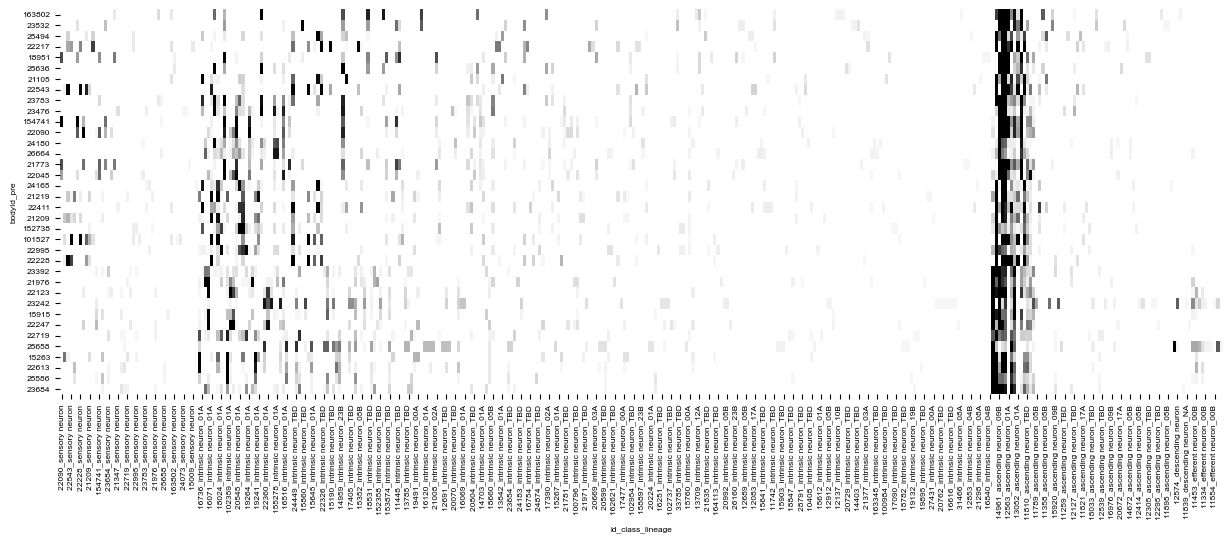

In [ ]:
custom_order = ['sensory neuron','intrinsic neuron', 'ascending neuron','descending neuron', 'efferent neuron', 'motor neuron']


# Sorting using the custom order
high_confidence_ds_df['class'] = pd.Categorical(high_confidence_ds_df['class'], categories=custom_order, ordered=True)
ordered = high_confidence_ds_df[high_confidence_ds_df.weight>=4].copy()

ordered['id_class_lineage'] = ordered.apply(generate_combined, axis=1)
ordered['weight_signed'] = ordered.apply(calculate_weight_signed, axis=1)

post = ordered.sort_values(['class', 'weight'], ascending=[True, False]).id_class_lineage.unique()
pre = high_confidence_ds_df.sort_values('instance_pre', ascending=True).bodyId_pre.unique()

relation = ordered.pivot_table(columns='id_class_lineage', index='bodyId_pre', values='weight', aggfunc='sum').fillna(0)
relation = relation[post].reindex(pre)

r = relation.drop_duplicates().copy()

fig = plt.figure(figsize=(15,5))
plt.rcParams["font.size"] = 6
sns.heatmap(r, vmin=0, vmax=50,cbar=False, cmap='Greys')
plt.show()


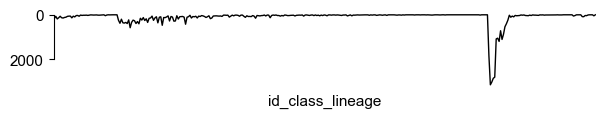

In [ ]:
col_totals = r.sum(axis=0)
row_totals = r.sum(axis=1)

fig = plt.figure(figsize=(7,1))
plt.rcParams["font.size"] = 11
d = sns.pointplot(x=col_totals.index, y=np.abs(col_totals.values),
              color='black', markersize=0, lw=1)
sns.despine(trim=True)
d.axes.get_xaxis().set_ticks([])

# Invert y-axis

d.axes.invert_yaxis() 

# Move x-axis to top

d.axes.spines['top'].set_position('zero')

d.axes.spines['bottom'].set_visible(False) 

plt.show()
